# Article Relevance Prediction for NeotomaDB
## Baseline Model with BOW Features

This notebook contains the following tasks:
1. Import cleaned data from "../data/processed/metadata_processed.csv"
2. Decisions on Features
3. Make preprocessing pipeline & Run baseline models with BOW features & Model Comparison
4. Feature Selection
5. Hyperparameter tuning
6. Summary

## 1. Data Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
pd.set_option("display.max_colwidth", 200)

In [9]:
# load csv
metadata_df = pd.read_csv("../data/processed/metadata_processed.csv", index_col=0)
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4435 entries, 0 to 4461
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DOI                     4435 non-null   object
 1   URL                     4435 non-null   object
 2   abstract                2080 non-null   object
 3   author                  3978 non-null   object
 4   container-title         4428 non-null   object
 5   is-referenced-by-count  4435 non-null   int64 
 6   language                4435 non-null   object
 7   published               4435 non-null   object
 8   publisher               4431 non-null   object
 9   subject                 4346 non-null   object
 10  subtitle                4435 non-null   object
 11  title                   4435 non-null   object
 12  target                  4435 non-null   int64 
 13  published_year          4435 non-null   int64 
 14  title_clean             4435 non-null   object
 15  subt

In [10]:
metadata_df.head(1)

,DOI,URL,abstract,author,container-title,is-referenced-by-count,language,published,publisher,subject,...,target,published_year,title_clean,subtitle_clean,abstract_clean,subject_clean,has_abstract,text_with_abstract,text_wo_abstract,detectlang
0,10.2478/s11756-007-0072-x,http://dx.doi.org/10.2478/s11756-007-0072-x,NaN,"[{'given': 'Miroslava', 'family': 'Pražáková', 'sequence': 'first', 'affiliation': []}, {'given': 'Josef', 'family': 'Veselý', 'sequence': 'additional', 'affiliation': []}, {'given': 'Jan', 'famil...",Biologia,13,en,"{'date-parts': [[2006, 12]]}",Springer Science and Business Media LLC,"['Cell Biology', 'Plant Science', 'Genetics', 'Molecular Biology', 'Animal Science and Zoology', 'Biochemistry', 'Ecology, Evolution, Behavior and Systematics']",...,1,2006,"The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest",NaN,NaN,"Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics",1,"The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest","The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest",en


## 2. Decisions on Features

| Variable | Description | Preprocessing |
| --- | --- | --- |
| DOI | Digital Object Identifier | Drop it during training. |
| URL | Link to the article | Drop it during training.|
|abstract | Abstract of the article. Only a small proportion of NeotomaDB articles has it. | Concatenate with title, then convert to Bag of Words representation|
|author | Author of the article | Consider droping due to duplicate names and various format and spelling |
|container-title | Title of the article's container | Decision: to make the model more generalizable to new journals, we will remove this feature. This also helps with dimension reduction with low cost of model performance. The subject feature is kept as a proxy of journal. |
| **is-referenced-by-count**| Count of the article being referenced by other article | Keep as a numeric feature.|
| language | Language of the article | Keep as a feature. Imputed with langdetect when missing. Only English articles are kept.|
| published | contain datatime information about when the article is published. | Decision: Drop the year of publication since it is not deemed as an informative feature.|
| publisher | Publisher name | Decision: drop to reduce dimension, and it is not a very informative feature. |
| **subject**| What subject the **journal** is about. | Keep as categorical feature. Bag of Words feature. |
| subtitle | Subtitle | Concatenate with title and then convert to Bag of words feature.|
| title | Title of the article. | Concatenate with title and abstract, then convert to Bag of words feature|
| **has_abstract** | Binary indicator.| Binary OHE feature.|
| **text_with_abstract** | Concatenated text: title + subtitle + abstract| BOW feature|
| text_wo_abstract | Concatenated text: title + subtitle (for experimental purpose) | Decision: We will use information from abstract to make better prediction.|
| detectlang | Imputed language using 'text_with_abstract' and detectlang package. | Value is used to impute missing language. Can be dropped now.|






In [15]:
training_keepcol = [
       'is-referenced-by-count', 
       'has_abstract', 
       'subject_clean',
       'text_with_abstract', 
       'target']

metadata_df_cleaned = metadata_df.loc[:, training_keepcol]

metadata_df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4435 entries, 0 to 4461
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  4435 non-null   int64 
 1   has_abstract            4435 non-null   int64 
 2   subject_clean           4435 non-null   object
 3   text_with_abstract      4435 non-null   object
 4   target                  4435 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 207.9+ KB


In [18]:
# Replace Missing value in subject_clean to empty string to avoid error in BOW transformer
metadata_df_cleaned['subject_clean'] = metadata_df_cleaned['subject_clean'].fillna('')
metadata_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4435 entries, 0 to 4434
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  4435 non-null   int64 
 1   has_abstract            4435 non-null   int64 
 2   subject_clean           4435 non-null   object
 3   text_with_abstract      4435 non-null   object
 4   target                  4435 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 173.4+ KB


In [20]:
metadata_df_cleaned = metadata_df_cleaned.reset_index().drop(columns="index")
metadata_df_cleaned.tail(2)

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target
4433,4,0,,"Clinical and radiological characteristics of COVID-19: a multicentre, retrospective, observational study Multicentre cohort investigations of patients with coronavirus disease 2019 (COVID-19) hav...",0
4434,9,0,Multidisciplinary,"Survival of forensic trace evidence on improvised explosive devices: perspectives on individualisation Improvised Explosive Devices (IEDs) are weapons of modern times, used by terrorist groups an...",0


## 3. Baseline Model with BOW Features

### 3.0 Imports

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

### 3.1 Train-Test Split

Decisions:
- We choose to allocate 20% of the data to test data. Since 4435 articles is not a very large amount of articles, we'd like to allocate more data to the training process.

In [22]:
train_df, test_df = train_test_split(metadata_df_cleaned, test_size=0.2, random_state=123)
train_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target
1094,2,1,"Ecology Aquatic Science Geography, Planning and Development",Guest Editor’s Introduction,0
1798,0,1,Applied Mathematics,Editorial Board,0
1843,16,1,Infectious Diseases,"Continued high incidence of children with severe influenza A(H1N1)pdm09 admitted to paediatric intensive care units in Germany during the first three post-pandemic influenza seasons, 2010/11–2012/...",0
1613,4,1,Economics and Econometrics,Biological Analogies in Economics: A Comment,0
168,20,1,"Ecology Ecology, Evolution, Behavior and Systematics",Postglacial Rise and Decline of Ostrya virginiana (Mill.) K. Koch and Carpinus caroliniana Walt. In Eastern North America: Predictable Responses of Forest Species to Cyclic Changes in Seasonality ...,1


### 3.2 EDA for Train Split

In [23]:
train_df.sort_index()
train_df.info() # check non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 1094 to 3582
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  3548 non-null   int64 
 1   has_abstract            3548 non-null   int64 
 2   subject_clean           3548 non-null   object
 3   text_with_abstract      3548 non-null   object
 4   target                  3548 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 166.3+ KB


In [24]:
pos_df = train_df[train_df["target"] == 1]
neg_df = train_df[train_df["target"] == 0]

In [26]:
print("With Abstract")
sorted_pos_df = pos_df.reindex(pos_df.text_with_abstract.str.len().sort_values().index)
sorted_neg_df = neg_df.reindex(neg_df.text_with_abstract.str.len().sort_values().index)
avg_pos_len = pos_df.text_with_abstract.str.len().mean()
avg_neg_len = neg_df.text_with_abstract.str.len().mean()
print(avg_pos_len)
print(avg_neg_len)


With Abstract
715.1986206896552
850.9546581650726


In [27]:
sorted_pos_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target
699,7,1,,In search of a palynological tundra,1
363,2,1,,Descriptions of WHOI sediment cores,1
437,3,1,"Plant Science Ecology, Evolution, Behavior and Systematics","5. Kožlí (S. Bohemia, Czech Republic)",1
194,33,1,Geology,"Tropical Lakes, Copropel, and Oil Shale",1
739,91,1,"Geology Archeology Ecology, Evolution, Behavior and Systematics",Younger Dryas in southern South America?,1


In [28]:
sorted_neg_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target
1558,0,1,Computational Theory and Mathematics Computer Networks and Communications Computer Science Applications Theoretical Computer Science Software,Note,0
1725,0,1,Economics and Econometrics,Reply,0
1451,0,1,Sociology and Political Science Veterinary (miscellaneous) Animal Science and Zoology Anthropology Education,Index,0
786,15,1,Religious studies Visual Arts and Performing Arts,Space,0
961,0,1,General Medicine Small Animals,Index,0


#### Word Cloud

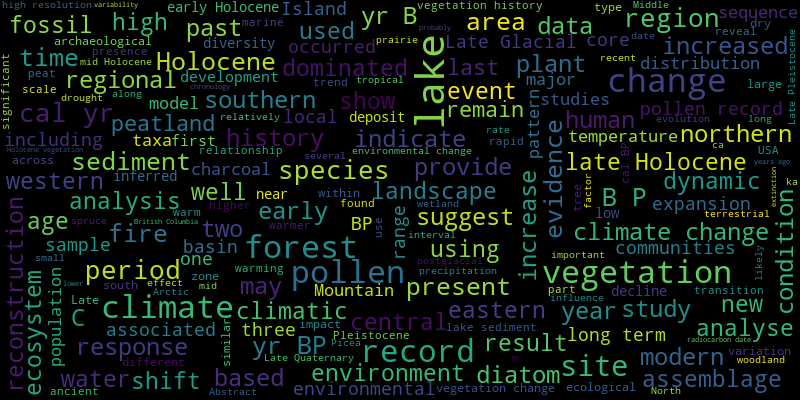

In [29]:
from wordcloud import WordCloud

pos_text = " ".join(train_df[train_df["target"] == 1]["text_with_abstract"].tolist())
neg_text = " ".join(train_df[train_df["target"] == 0]["text_with_abstract"].tolist())

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(pos_text).to_image()

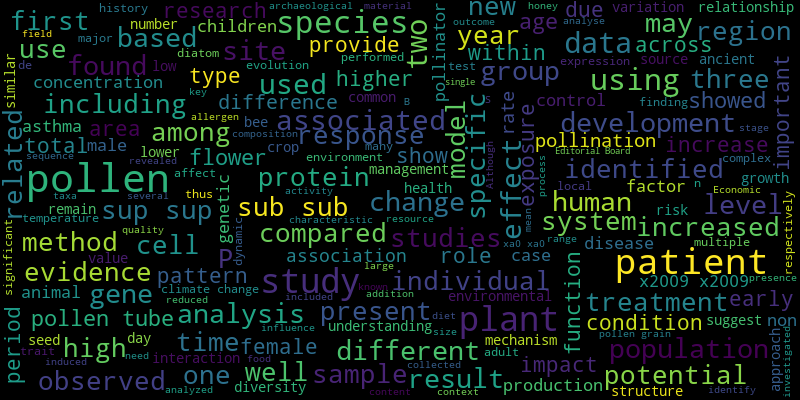

In [30]:
wordcloud.generate(neg_text).to_image()

#### Examine class distribution in train split

In [31]:
train_df["target"].value_counts(normalize=True)

0    0.79566
1    0.20434
Name: target, dtype: float64

## 3.3 Define Preprocessor

In [32]:
train_df.columns

Index(['is-referenced-by-count', 'has_abstract', 'subject_clean',
       'text_with_abstract', 'target'],
      dtype='object')

In [33]:
X_train, y_train = train_df.drop(columns = ["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns = ["target"]), test_df["target"]

In [35]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer

# Dividing the feature types

numeric_features = ["is-referenced-by-count"]
numeric_transformer = StandardScaler()

binary_feature = ['has_abstract']
binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)

subject_feature = 'subject_clean'
subject_transformer = CountVectorizer(stop_words="english", max_features= 1000)

text_feature = "text_with_abstract"
text_transformer = CountVectorizer(stop_words="english", max_features= 1000)

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers = [
    ("num_preprocessor", numeric_transformer, numeric_features),
    ("binary_preprossor", binary_transformer, binary_feature),
    ("subject_preprocessor", text_transformer, subject_feature),
    ("text_preprocessor", text_transformer, text_feature)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num_preprocessor', StandardScaler(),
                                 ['is-referenced-by-count']),
                                ('binary_preprossor',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['has_abstract']),
                                ('subject_preprocessor',
                                 CountVectorizer(max_features=1000,
                                                 stop_words='english'),
                                 'subject_clean'),
                                ('text_preprocessor',
                                 CountVectorizer(max_features=1000,
                                                 stop_words='english'),
                                 'text_with_abstract')])

##### Check Transformed Data

In [43]:
transformed_X_train = preprocessor.fit_transform(X_train)
transformed_X_train

<3548x1325 sparse matrix of type '<class 'numpy.float64'>'
	with 111462 stored elements in Compressed Sparse Row format>

In [41]:
col_names = (preprocessor.named_transformers_["num_preprocessor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["binary_preprossor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["subject_preprocessor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["text_preprocessor"].get_feature_names_out().tolist()
             )
len(col_names)

1325

In [48]:
# Number of features from descriptive text 
len(preprocessor.named_transformers_["text_preprocessor"].get_feature_names_out().tolist())

1000

In [49]:
# Number of features from subject
len(preprocessor.named_transformers_["subject_preprocessor"].get_feature_names_out().tolist())

323

In [50]:
transformed_X_train_df = pd.DataFrame.sparse.from_spmatrix(transformed_X_train, columns=col_names)
transformed_X_train_df.head()

,is-referenced-by-count,has_abstract_1,accounting,administration,advanced,aerospace,aging,agricultural,agronomy,aided,...,x442,xa0,xb1,xe9,year,years,yield,younger,yr,zone
0,-0.335283,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.386422,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.022687,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.284144,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.124964,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.4 Baseline Models Comparison

In [51]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from lightgbm.sklearn import LGBMClassifier

In [52]:
# Helper function for comparing models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns pandas Series with mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)


In [54]:
classification_metrics = ["accuracy", "precision", "recall", "f1"]

In [55]:
results_dict = {}
models = {
	"dummy": DummyClassifier(random_state = 123),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=123),
    "Decision Tree": DecisionTreeClassifier(random_state=123, max_depth=200),
    "kNN": KNeighborsClassifier(),
    'Naive Bayes': BernoulliNB(),
    "RBF SVM": SVC(random_state=123),
    'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
    'LGBM': LGBMClassifier(random_state=123)
    }

for key, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[key] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True, 
                                                  scoring=classification_metrics)

results_df = pd.DataFrame(results_dict).T
results_df

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy,0.270 (+/- 0.028),0.065 (+/- 0.011),0.796 (+/- 0.000),0.796 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.314 (+/- 0.045),0.056 (+/- 0.003),0.951 (+/- 0.006),0.995 (+/- 0.000),0.893 (+/- 0.017),0.999 (+/- 0.001),0.863 (+/- 0.023),0.977 (+/- 0.003),0.878 (+/- 0.016),0.988 (+/- 0.001)
Decision Tree,0.333 (+/- 0.040),0.058 (+/- 0.006),0.919 (+/- 0.011),1.000 (+/- 0.000),0.787 (+/- 0.028),1.000 (+/- 0.000),0.832 (+/- 0.028),1.000 (+/- 0.000),0.808 (+/- 0.024),1.000 (+/- 0.000)
kNN,0.290 (+/- 0.029),0.661 (+/- 0.029),0.893 (+/- 0.012),0.930 (+/- 0.003),0.722 (+/- 0.025),0.814 (+/- 0.013),0.778 (+/- 0.046),0.851 (+/- 0.011),0.749 (+/- 0.032),0.832 (+/- 0.008)
Naive Bayes,0.271 (+/- 0.032),0.061 (+/- 0.004),0.934 (+/- 0.008),0.941 (+/- 0.002),0.794 (+/- 0.024),0.809 (+/- 0.007),0.917 (+/- 0.023),0.933 (+/- 0.004),0.851 (+/- 0.016),0.867 (+/- 0.004)
RBF SVM,0.870 (+/- 0.074),0.217 (+/- 0.014),0.942 (+/- 0.006),0.972 (+/- 0.003),0.949 (+/- 0.014),0.988 (+/- 0.005),0.759 (+/- 0.037),0.873 (+/- 0.014),0.843 (+/- 0.020),0.927 (+/- 0.008)
RF,0.903 (+/- 0.075),0.075 (+/- 0.004),0.962 (+/- 0.008),1.000 (+/- 0.000),0.950 (+/- 0.021),1.000 (+/- 0.000),0.859 (+/- 0.024),1.000 (+/- 0.000),0.902 (+/- 0.022),1.000 (+/- 0.000)
LGBM,0.528 (+/- 0.041),0.083 (+/- 0.005),0.961 (+/- 0.003),1.000 (+/- 0.000),0.933 (+/- 0.017),1.000 (+/- 0.000),0.872 (+/- 0.019),0.998 (+/- 0.001),0.901 (+/- 0.008),0.999 (+/- 0.001)


##### Summary
- Test Recall: Naive Bayes > LGBM > Logistic regression > RF
- Test Precision: RF > SVM > LGBM > Logistic regression
- Test f1: RF ~ LGBM > Logistic regression > Naive Bayes > SVM
- Model overfit: there are signs of overfit, require hyperparameter tuning and feature selection

## 4. Feature Selection

Based on the initial results, we will apply feature selection to selected models.


## 5. Model Evaluation

#### Logistic Regression

In [224]:
from sklearn.linear_model import LogisticRegression 

# The model pipeline

logreg_model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe

classification_metrics = ["accuracy", "precision", "recall", "f1"]

cross_val_results= {}
cross_val_results['logreg'] = pd.DataFrame(
    cross_validate(
        logreg_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

cross_val_results['logreg']

,mean,std
fit_time,0.115,0.015
score_time,0.018,0.003
test_accuracy,0.965,0.006
train_accuracy,0.975,0.002
test_precision,0.949,0.020
train_precision,0.970,0.006
test_recall,0.874,0.019
train_recall,0.905,0.004
test_f1,0.910,0.015
train_f1,0.936,0.005


#### LogReg - Preliminary investigation on feature importance for Logistic Regression

In [225]:
model_params = logreg_model.named_steps['logisticregression'].get_params()
model_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [226]:
logreg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprossor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('bow_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean'),
                                                 ('drop', 'drop',
                                                  ['container-title'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=123))])

In [227]:
data = {
    "coefficient": logreg_model.named_steps['logisticregression'].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        logreg_model.named_steps['logisticregression'].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

,coefficient,magnitude
128,2.058261,2.058261
has_abstract_1,1.647876,1.647876
332,1.601820,1.601820
190,1.570269,1.570269
96,1.496357,1.496357
273,1.468023,1.468023
162,1.446443,1.446443
18,1.365346,1.365346
323,1.340720,1.340720
321,1.335135,1.335135


In [228]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

,coefficient,magnitude
159,-1.996517,1.996517
191,-1.687162,1.687162
73,-1.588027,1.588027
311,-1.489114,1.489114
26,-1.394945,1.394945
148,-1.303475,1.303475
229,-1.285626,1.285626
44,-1.245813,1.245813
245,-1.230201,1.230201
52,-1.224384,1.224384


#### Recall by Group

In [229]:
from sklearn.metrics import recall_score
# Make predictions
predictions = logreg_model.predict(X_train)

# Add the predictions to the original DataFrame
train_df['predictions'] = predictions

# Group the data by a specific feature
grouped_data = train_df.groupby('has_abstract')

# Calculate recall for each group
grouped_recall = grouped_data.apply(lambda x: recall_score(x['target'], x['predictions']))

# Print the recall by group
print(grouped_recall)

has_abstract
0    0.811321
1    0.972973
dtype: float64


#### Model Mistakes

In [230]:
logreg_model.fit(X_train, y_train)

train_df['y_pred'] = logreg_model.predict(X_train)
# train_df['y_predictproba'] = logreg_model.predict_proba(X_train)

train_df.head(5)

# False Positives
train_df.query('target == 0 & y_pred == 1').head()

# False Negative
train_df.query('target == 1 & y_pred == 0').head()


,is-referenced-by-count,has_abstract,container-title,language,subject_clean,text_with_abstract,text_wo_abstract,target,0,1,...,376,377,378,379,380,381,382,383,predictions,y_pred
3546,5,0,Science,en,Multidisciplinary,"Droughts and societal change: The environmental context for the emergence of Islam in late Antique Arabia In Arabia, the first half of the sixth century CE was marked by the demise of Himyar, the...",Droughts and societal change: The environmental context for the emergence of Islam in late Antique Arabia,1,-0.007667,0.135362,...,0.046464,0.000131,-0.022820,-0.026862,0.062914,-0.029203,0.021492,-0.020467,0,0
3326,6,0,Oecologia,en,"Ecology, Evolution, Behavior and Systematics",Predicting habitat use by the Argentine hake Merluccius hubbsi in a warmer world: inferences from the Middle Holocene Fish skeletal remains recovered from two archaeological sites dated in the Mi...,Predicting habitat use by the Argentine hake Merluccius hubbsi in a warmer world: inferences from the Middle Holocene,1,-0.045271,0.101332,...,0.048800,-0.006095,-0.027394,0.069519,0.077004,-0.029384,-0.054234,0.000457,0,0
3374,12,0,Scientific Data,en,"Library and Information Sciences Statistics, Probability and Uncertainty Computer Science Applications Education Information Systems Statistics and Probability","p3k14c, a synthetic global database of archaeological radiocarbon dates Archaeologists increasingly use large radiocarbon databases to model prehistoric human demography (also termed paleo-demogr...","p3k14c, a synthetic global database of archaeological radiocarbon dates",1,-0.075282,0.070110,...,0.058668,0.033686,0.021805,-0.020881,0.123094,-0.104703,-0.093247,-0.050356,0,0
2617,32,0,Nature,en,Multidisciplinary,"Dire wolves were the last of an ancient New World canid lineage Dire wolves are considered to be one of the most common and widespread large carnivores in Pleistocene America<sup>1</sup>, yet rel...",Dire wolves were the last of an ancient New World canid lineage,1,-0.159181,0.024300,...,0.022273,-0.021869,0.022916,0.083337,0.056286,-0.064959,0.041914,-0.012493,0,0
3925,6,0,Data in Brief,en,Multidisciplinary,"A dataset for distribution and characteristics of Holocene pyroclastic fall deposits along the Pacific coasts in western Hokkaido, Japan The tephra layers known with eruption ages play an importa...","A dataset for distribution and characteristics of Holocene pyroclastic fall deposits along the Pacific coasts in western Hokkaido, Japan",1,-0.013847,0.042167,...,0.066377,-0.018755,-0.027124,0.047283,0.057765,0.006733,-0.084097,-0.026971,0,0


### Build and Compare Multiple Models

Note: Remove year, Using Abstract, Using Author

In [296]:
# Helper function for comparing models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns pandas Series with mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)


In [297]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from lightgbm.sklearn import LGBMClassifier

results_dict = {}
models = {
	"dummy": DummyClassifier(random_state = 123),
    'logisticRegression': LogisticRegression(max_iter=1000, random_state=123),
    "decision tree": DecisionTreeClassifier(random_state=123, max_depth=200),
    "kNN": KNeighborsClassifier(),
    'NaiveBayes': BernoulliNB(),
    "RBF SVM": SVC(random_state=123),
    'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
    'LGBM': LGBMClassifier(random_state=123)
    }

for key, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[key] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True, scoring=classification_metrics)

results_df = pd.DataFrame(results_dict).T
results_df



/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy,0.049 (+/- 0.010),0.020 (+/- 0.002),0.796 (+/- 0.000),0.796 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
logisticRegression,0.763 (+/- 0.109),0.068 (+/- 0.003),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan)
decision tree,3.299 (+/- 0.539),0.059 (+/- 0.006),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan)
kNN,0.042 (+/- 0.002),0.054 (+/- 0.005),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan)
NaiveBayes,0.094 (+/- 0.007),0.058 (+/- 0.005),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan)
RBF SVM,1.018 (+/- 0.078),0.059 (+/- 0.003),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan)
RF,4.369 (+/- 0.124),0.057 (+/- 0.003),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan)
LGBM,4.069 (+/- 0.284),0.070 (+/- 0.006),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan)


### Feature Selection

#### Intermediate Results Summary (Latest Data, With Sentence Embeddings)

- Word Embedding, Journal Name, OHE subject
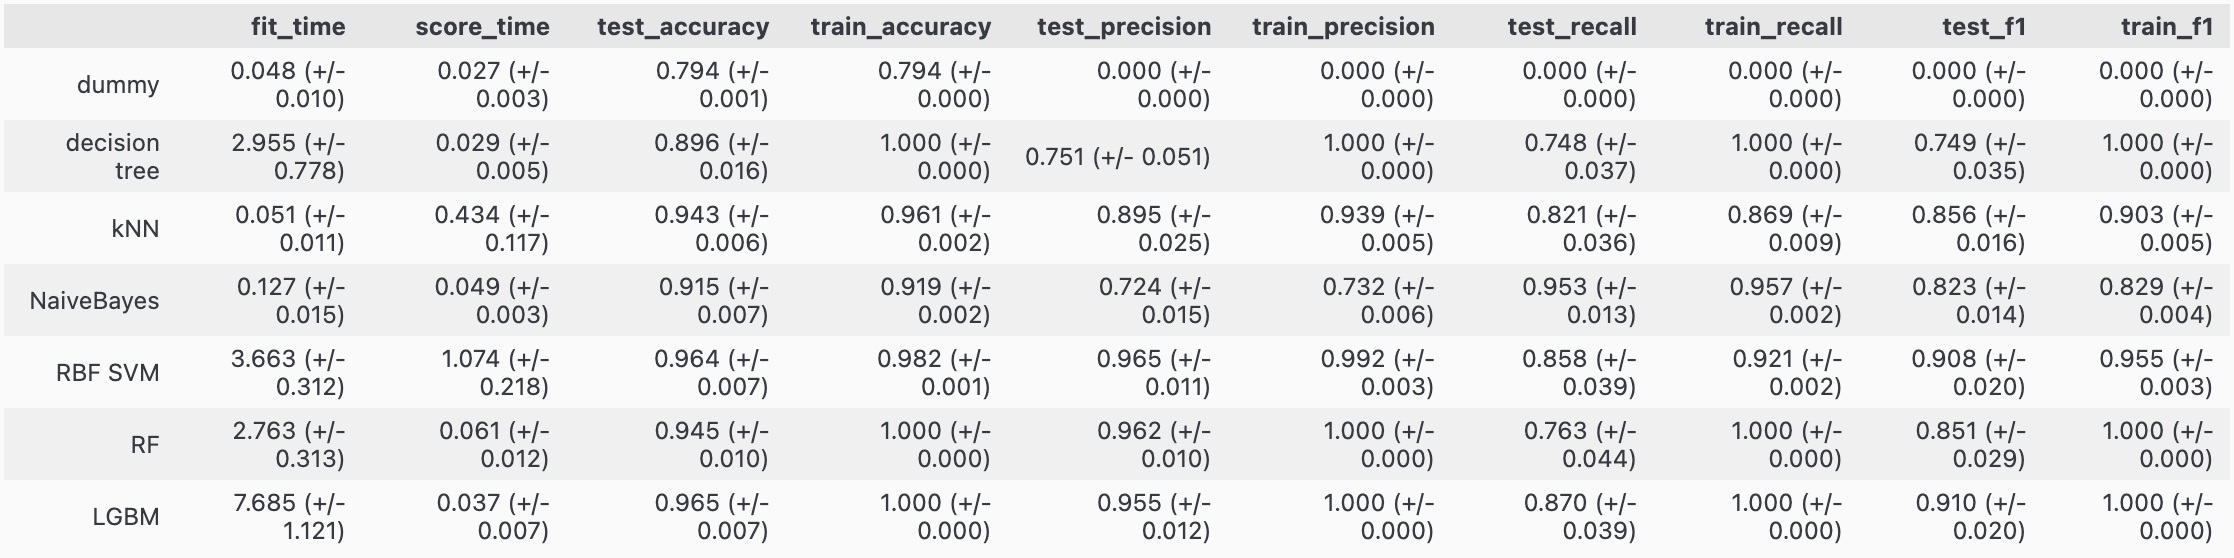

- Word Embeddings, Journal Name, BOW subject

Converting OHE subject to BOW subject reduced dimension by around 350

Xtrain has 1891 input features

Test recall improved for LGBM
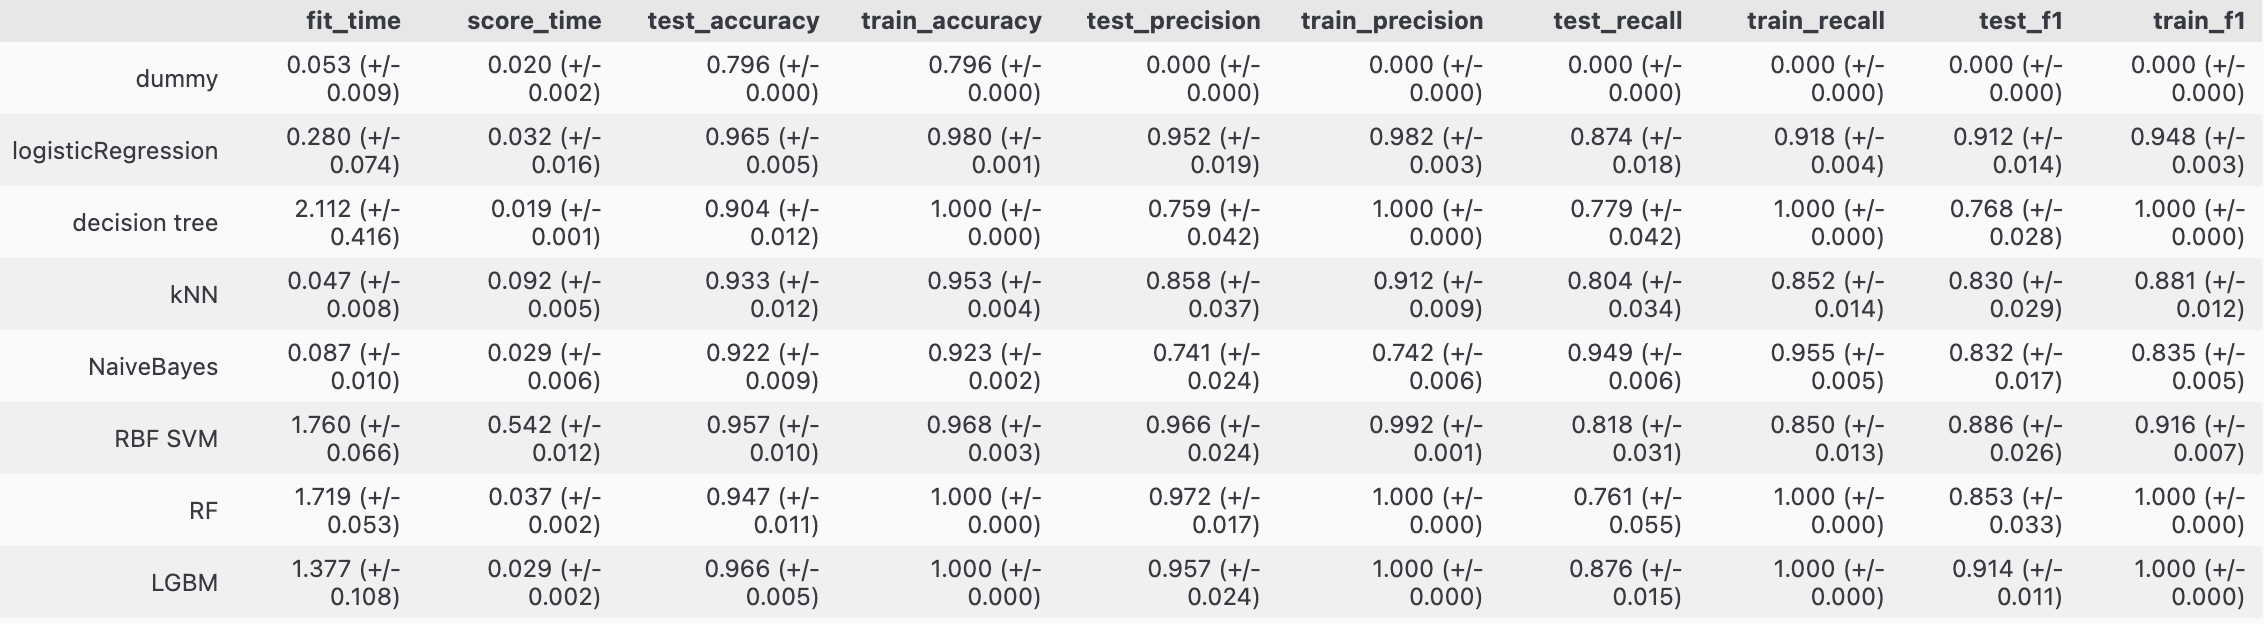

- Word Embeddings, Remove Journal Name, BOW subject

Removing Journal name reduce the dimension of input X_train to 709 features only.

This also makes the model more generalizable and does not rely on journal titles. 

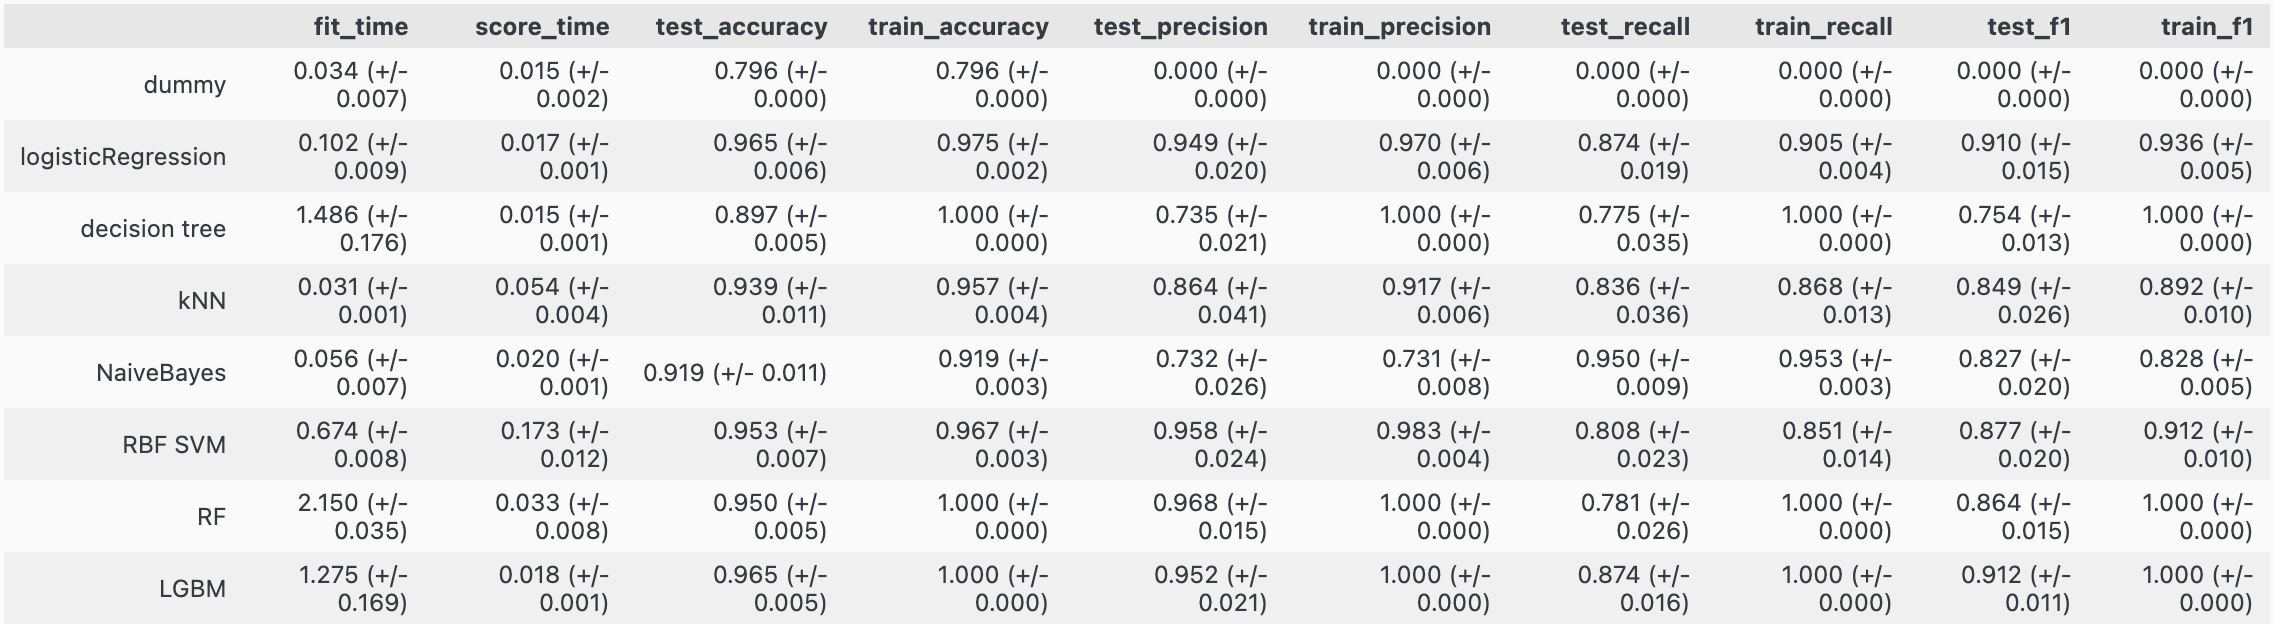

- Word Embeddings, Remove Journal Name, BOW subject, + transformer's paleoecology probability prediction

Using bert-base-uncased model, the output does not seem to be trustworthy:

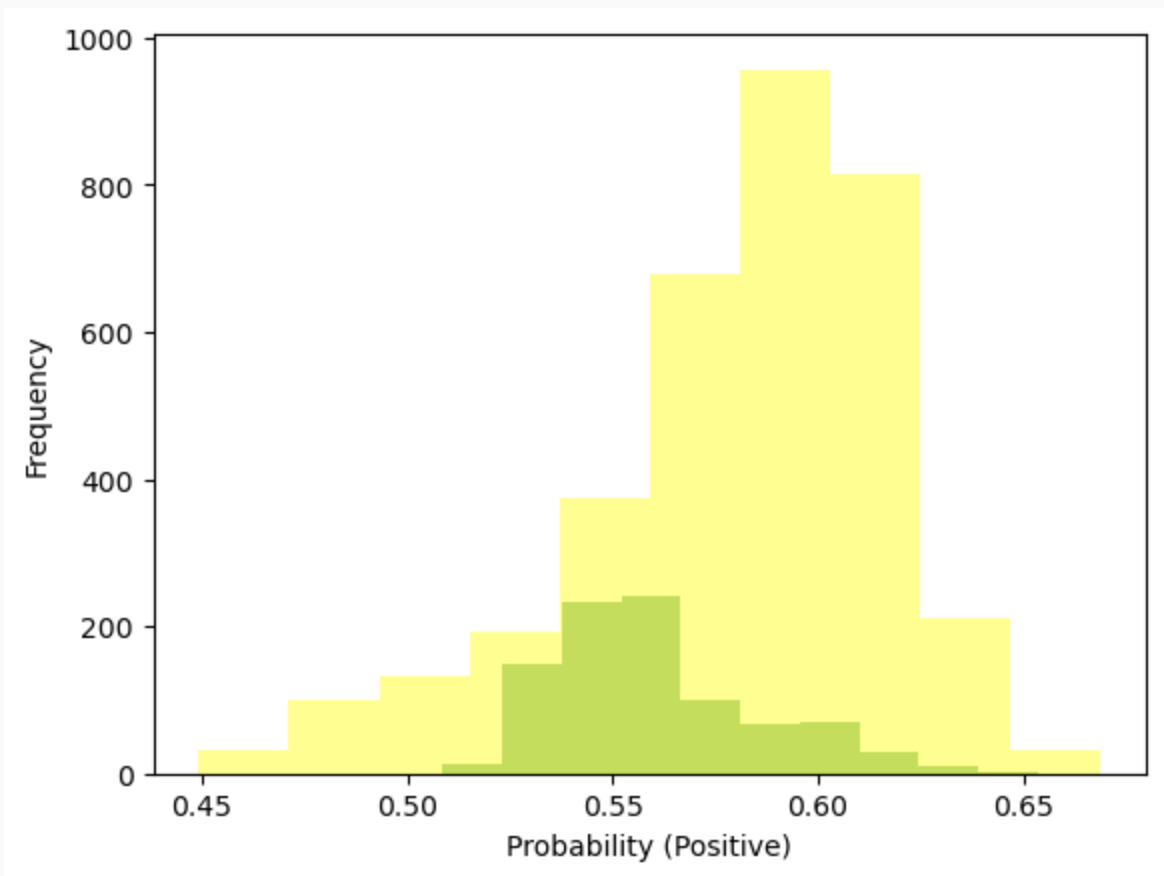{ width=500 height=400 }

### Model Evaluation and Interpretation

- So far, the best model is: 
    - Naive Bayes with word embeddings, no journal title, and bow subject. (Though it could introduce more false positives)

In [259]:
final_pipeline = make_pipeline(preprocessor, BernoulliNB(alpha=1))
final_pipeline.fit(X_train, y_train)

test_score = final_pipeline.score(X_test, y_test)
test_score

0.8996617812852311

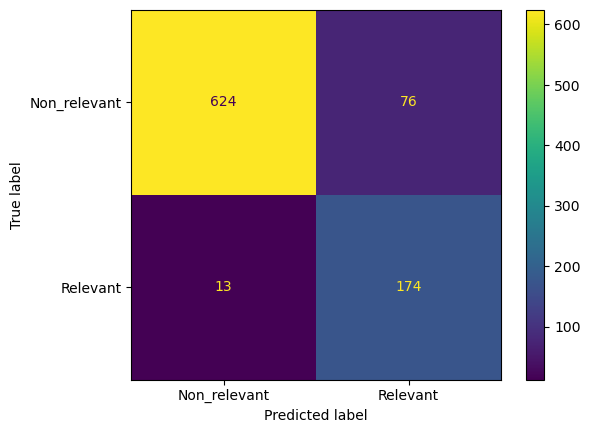

In [260]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay.from_estimator(
    final_pipeline, X_test, y_test, values_format="d", display_labels=["Non_relevant", "Relevant"]
)


In [261]:
from sklearn.metrics import precision_recall_curve

precision_lr, recall_lr, thresholds_lr = precision_recall_curve(
	y_test, final_pipeline.predict_proba(X_test)[:, 1])


#### Intermediate Results Summary (During iteration 2, for feature engineering : with data from May12)

- Exclude abstract, use binary author, keep OHE journal:
![result1](../assets/author_binary.png)

- Exclude abstract, use binary author and binary journal:
![result2](../assets/author_journal_binary.png)



- Exclude abstract, use 3-category author, ordinal journal, imputed language

![image.png](attachment:image.png)

- Exclude abstract, Exclude 3-category author; Use ordinal journal, imputed language

(conclusion: Author seems to be a informative variable)

![image.png](attachment:image.png)

- Include Abstract, use 3-category author, ordinal journal, imputed language
![image.png](attachment:image.png)

- Drop Year, Include Abstract, use 3-category author, ordinal journal, imputed language

![image.png](attachment:image.png)

#### LogReg - Hyperparameter Tuning for Logistic Regression

In [ ]:
# from scipy.stats import loguniform, randint

# # fit the model
# logreg_model.fit(X_train, y_train)

# # get the length of the vocabulary
# vocab_len = len(  
#     logreg_model.named_steps["columntransformer"]
#     .named_transformers_["countvectorizer"]
#     .get_feature_names_out()
# )
# # create a distribution of the parameters
# param_dist = {  
#     # "columntransformer__countvectorizer__max_features": np.arange(5000, vocab_len, 200),
#     "logisticregression__C": loguniform(1e-3, 1e3),
#     "logisticregression__class_weight": ["balanced", None],
# }

# # Perform a randomized search 
# random_search = RandomizedSearchCV(  
#     logreg_model,
#     param_distributions=param_dist,
#     n_iter=10,
#     verbose=1,
#     n_jobs=-1,
#     scoring='recall',
#     random_state=123,
# )
# random_search.fit(X_train, y_train)